In [1]:
# Import image processing libraries

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

from scipy import ndimage

In [2]:
# Auxiliar functions

def save_image(img, name):
    cv2.imwrite(name, reverse(img))
    
def reverse(img):
    return np.where(img == 0, 1, 0)

def plot_image(img, title):
    plt.imshow(reverse(img), cmap=plt.cm.gray)
    plt.title(title), plt.axis('off')
    plt.show()

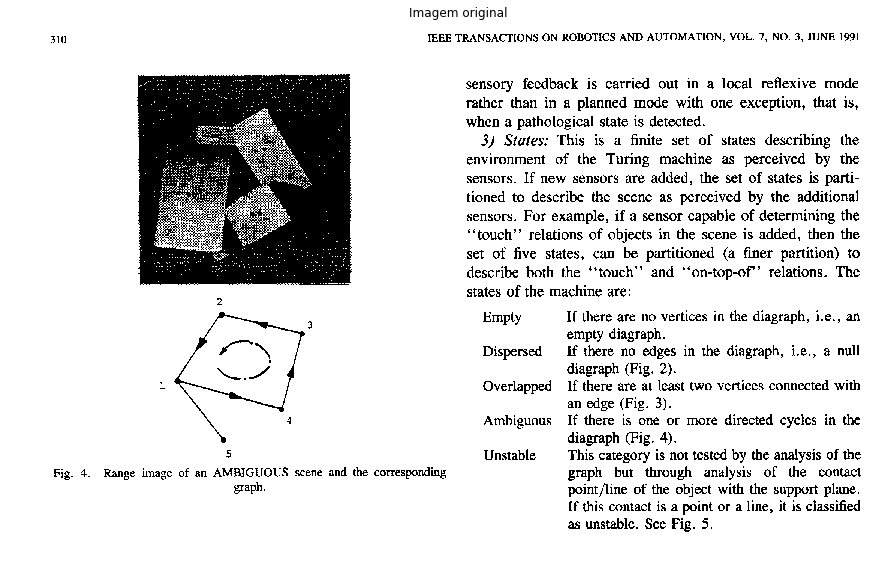

In [3]:
IMAGE_FILE = "bitmap.pbm"
IMAGE_NAME = IMAGE_FILE.split('.')[0]

# Create the directories to store the results
if not os.path.exists('res/{}'.format(IMAGE_NAME)):
    os.makedirs('res/{}'.format(IMAGE_NAME))
    os.makedirs('res/{}/texts'.format(IMAGE_NAME))
    os.makedirs('res/{}/not_texts'.format(IMAGE_NAME))

# open the image and do the gray conversion
img = cv2.imread(IMAGE_FILE)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = reverse(img)

plt.rcParams["figure.figsize"] = (15,15)

plot_image(img, "Imagem original")

In [4]:
# Check if the image contains only 0 and 255
len(img[img == 1]) + len(img[img == 0]) == img.size

True

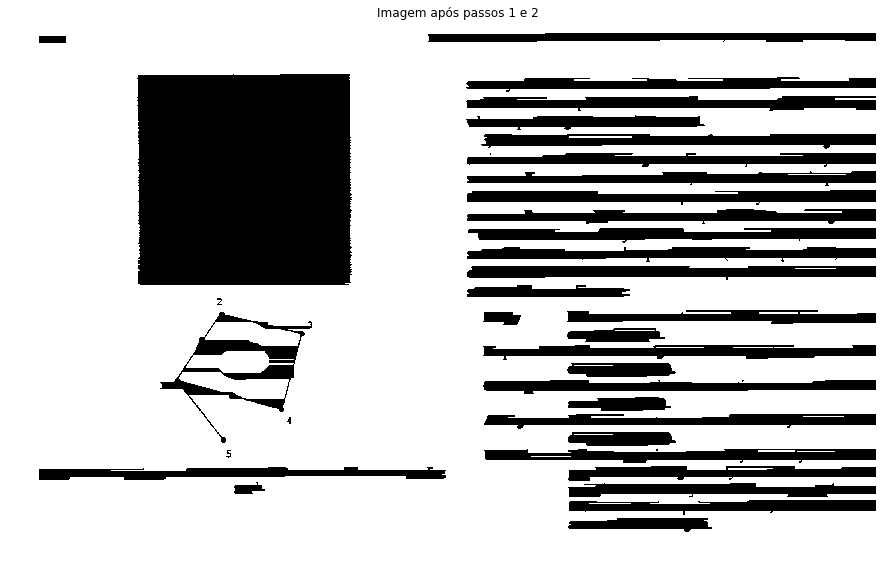

In [5]:
# Step 1 and 2
image_1 = img.copy()

structure_1 = np.ones((1, 100))

image_1 = ndimage.morphology.binary_dilation(image_1, structure_1, border_value=1).astype(image_1.dtype)
image_1 = ndimage.morphology.binary_erosion(image_1, structure_1, border_value=1).astype(image_1.dtype)

plot_image(image_1, "Imagem após passos 1 e 2")

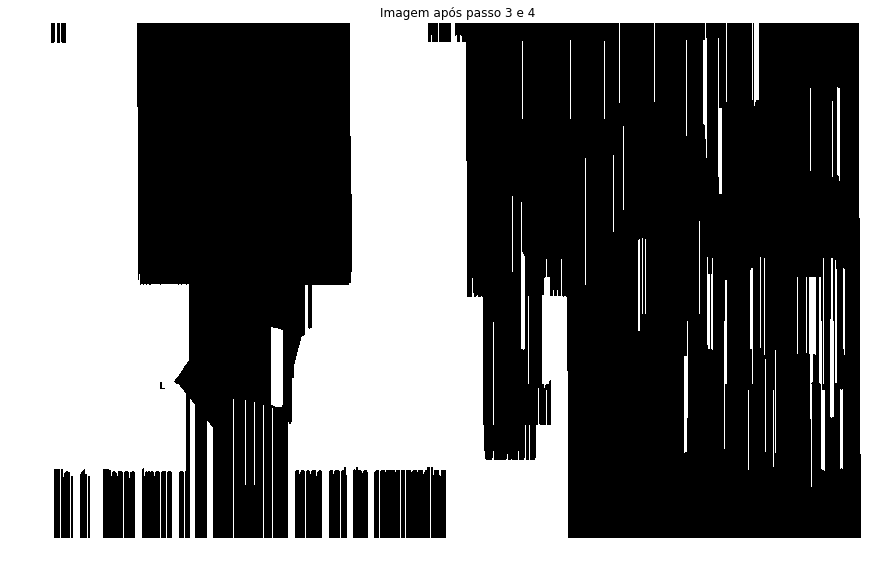

In [6]:
# Step 3 and 4
image_2 = img.copy()

structure_2 = np.ones((200, 1))
image_2 = ndimage.morphology.binary_dilation(image_2, structure_2, border_value=1).astype(image_2.dtype)
image_2 = ndimage.morphology.binary_erosion(image_2, structure_2, border_value=1).astype(image_2.dtype)

plot_image(image_2, "Imagem após passo 3 e 4")

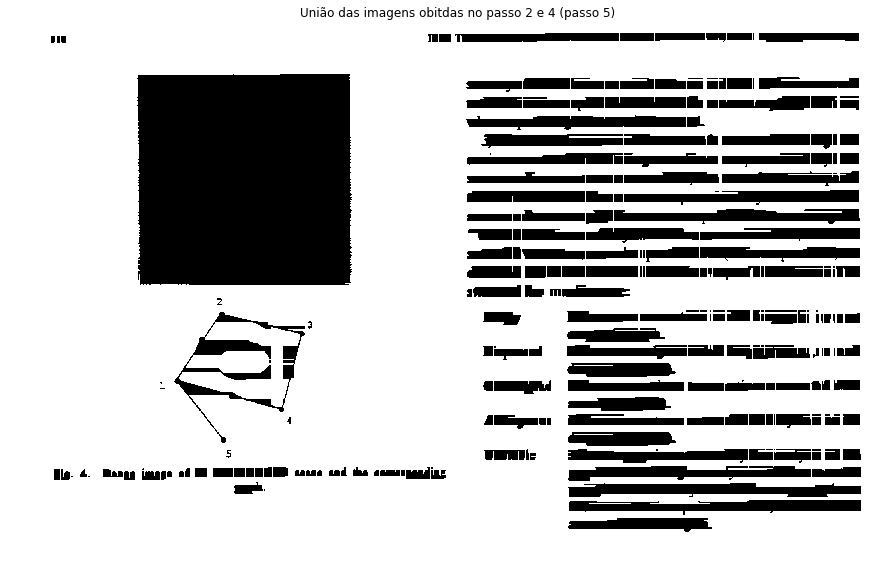

In [7]:
# Step 5 (Result 1 AND Result 2)
plot_image(image_1 & image_2, "União das imagens obitdas no passo 2 e 4 (passo 5)")

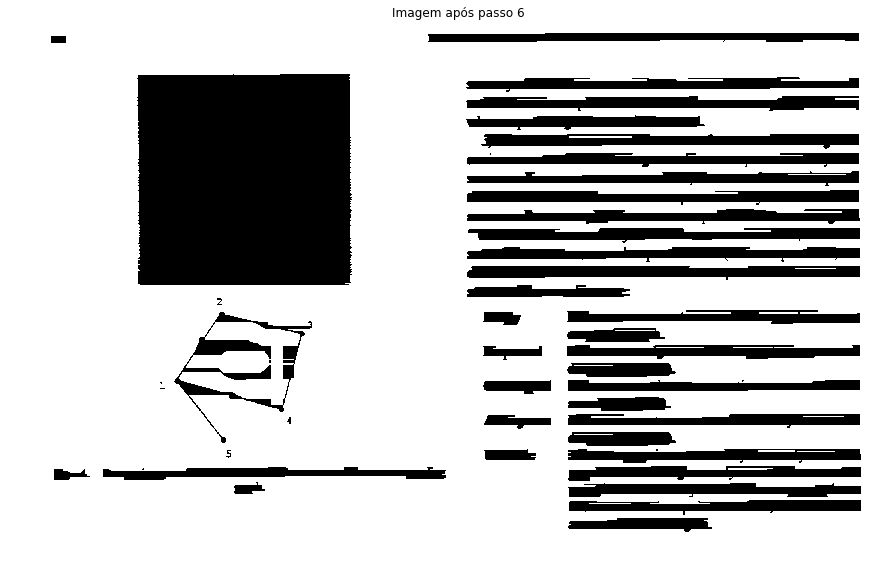

In [8]:
# Step 6 
structure_3 = np.ones((1,30))

res = ndimage.binary_closing((image_1 & image_2), structure_3, border_value=1).astype((image_1 & image_2).dtype)

plot_image(res, "Imagem após passo 6")

In [9]:
def get_subimg(img, top_left, bottom_right):
    '''Given an imagem and the coordinates of a rectangle (top_left and bottom_right points)
    
    Returns: the subimage
    '''
    return img[top_left[0] : bottom_right[0], top_left[1] : bottom_right[1]]

def draw_rectangle(img, top_left, bottom_right, border=1):
    '''Given an imagem and the coordinates of a rectangle (top_left and bottom_right points)
    Draw a rectangle (this modify the parameter)
    '''
    limit_i = res.shape[0]
    limit_j = res.shape[1]
    
    # Draw the left vertical line
    img[top_left[0] : bottom_right[0], top_left[1] : min(top_left[1] + border, limit_j + 1)] = 255
    # Draw the right vertical line
    img[top_left[0] : bottom_right[0], bottom_right[1] : min(bottom_right[1] + border, limit_j + 1)] = 255
    # Draw the top horizontal line
    img[top_left[0] : min(top_left[0] + border, limit_i + 1), top_left[1] : bottom_right[1]] = 255
    # Draw the bottom horizontal line
    img[bottom_right[0]: min(bottom_right[0]+ border, limit_i + 1), top_left[1] : bottom_right[1]] = 255
    
def get_rectangles_conexed_components(target, original):
    '''Given a target containing all the morphological operations and the original image
    
    Return a list containing all rectangles that has a conexed component
    '''
    rectangles = []
    indices = np.indices(target.shape)
    indices = indices.swapaxes(0, -1).swapaxes(0, 1)
    
    limit_i = target.shape[0]
    limit_j = target.shape[1]
    
    labeled, ncomponents = ndimage.measurements.label(target)
    
    for i in range(1, ncomponents + 1):
        indexes = np.split(indices[labeled==i], 2, axis=1)
        indexes_i = indexes[0].reshape(-1)
        indexes_j = indexes[1].reshape(-1)
        
        # Get the minimal and maximal points of coordinates x and y to generate top_left and bottom_right points
        min_i = min(indexes_i)
        min_j = min(indexes_j)
        max_i = max(indexes_i)
        max_j = max(indexes_j)

        top_left = (min_i, min_j)
        bottom_right = (min(max_i+1, limit_i + 1), min(max_j+1, limit_j + 1))
        
        img_component = get_subimg(original, top_left, bottom_right)

        # Check if the img component contain anything or just morphological noise
        if img_component[img_component == 1].size > 0:
            rectangles.append((top_left, bottom_right))
    return rectangles

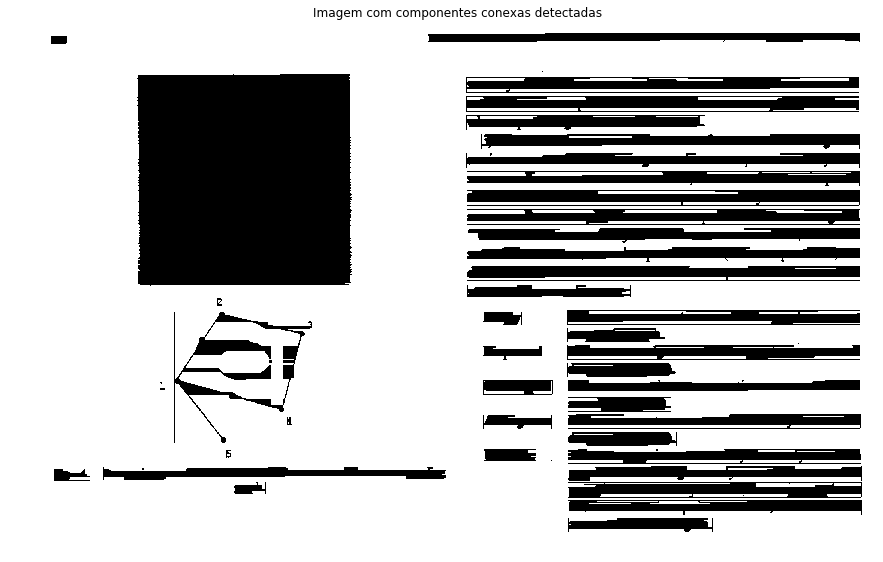

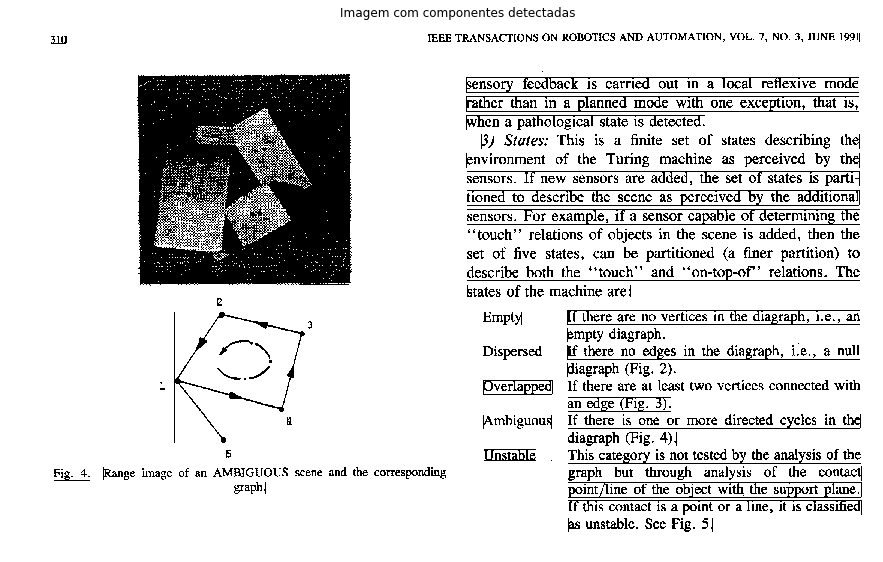

53

In [10]:
# Draw the rectangles containing conexed components
rectangles = get_rectangles_conexed_components(res, img)

res_components = res.copy()
img_components = img.copy()

for i, rectangle in enumerate(rectangles):
    top_left = rectangle[0]
    bottom_right = rectangle[1]
    
    img_component = get_subimg(img, top_left, bottom_right)
    res_component = get_subimg(res, top_left, bottom_right)
    
    if img_component[(img_component & res_component) == 1].size > 0:
        draw_rectangle(res_components, top_left, bottom_right)
        draw_rectangle(img_components, top_left, bottom_right)

        save_image(img_component, 'res/{}/component{}.pbm'.format(IMAGE_NAME, i + 1))

plot_image(res_components, "Imagem com componentes conexas detectadas")
plot_image(img_components, "Imagem com componentes detectadas")
save_image(res_components, 'res/{}/img_border_components.pbm'.format(IMAGE_NAME))
save_image(img_components, 'res/{}/img_border.pbm'.format(IMAGE_NAME))

len(rectangles)

In [11]:
def black_proportion(img):
    '''
    Given an image, return the black pixel proportion
    '''
    return img[img != 0].size / img.size

In [12]:
# Checking the best proportion to classify the texts
actual_max = 0
actual_min = 1
lines_count = 0

print(' N   Result?  Proportion:')
for i, rectangle in enumerate(rectangles):
    top_left = rectangle[0]
    bottom_right = rectangle[1]
    component = get_subimg(img, top_left, bottom_right)
    proportion = black_proportion(component)
    
    print('{:2d}        {}   {}'.format(
        i + 1,
        'T' if proportion > 0.15 and proportion < 0.60 else 'F',
        proportion
    ))

    if proportion > 0.15 and proportion < 0.60:
        actual_max = max(actual_max, proportion)
        actual_min = min(actual_min, proportion)
        lines_count += 1
    
print(actual_min)
print(actual_max)
print('Total lines: {}'.format(lines_count))

 N   Result?  Proportion:
 1        T   0.2975152041702867
 2        T   0.373015873015873
 3        F   0.75
 4        F   1.0
 5        F   0.8300742635429024
 6        T   0.21494746895893027
 7        T   0.222468958930277
 8        T   0.2551221672100793
 9        T   0.2051027676027676
10        T   0.20885019083969467
11        F   0.9
12        T   0.2183654458989067
13        T   0.2169054441260745
14        T   0.2343839541547278
15        T   0.22119617224880384
16        T   0.21666299316729115
17        T   0.2103445742414224
18        F   1.0
19        T   0.30589543937708563
20        T   0.4666666666666667
21        T   0.22209917984565872
22        F   0.06216281629880624
23        T   0.3106796116504854
24        T   0.2818680749715233
25        F   1.0
26        T   0.2178044342610688
27        T   0.2955867259664728
28        F   0.8035714285714286
29        T   0.2617059891107078
30        T   0.2878205128205128
31        F   0.8
32        T   0.29009988249118684
3

In [13]:
def count_horizontal_inversions(img):
    '''
    Given an image return the horizontal inversion (0 to 1) of the image
    '''
    left_right = np.count_nonzero((img[...,:-1] == 0) & (img[...,1:] == 1))
    right_left = np.count_nonzero((img[...,1:] == 1) & (img[...,:-1] == 0))
    return left_right + right_left

def count_vertical_inversions(img):
    '''
    Given an image return the vertical inversion (0 to 1) of the image
    '''
    up_bottom = np.count_nonzero((img[:-1] == 0) & (img[1:] == 1))
    bottom_up = np.count_nonzero((img[1:] == 1) & (img[:-1] == 0))
    return up_bottom + bottom_up

def inversions_proportion(img):
    '''
    Given an image return the proportion of inversions by the number of black pixels
    '''
    return (count_horizontal_inversions(img) + count_vertical_inversions(img)) / img[img != 0].size

In [14]:
# Checking the best proportion to classify the texts
actual_max = 0
actual_min = 1
lines_count = 0

print(' N   Result?   Proportion:')
for i, rectangle in enumerate(rectangles):
    top_left = rectangle[0]
    bottom_right = rectangle[1]
    component = get_subimg(img, top_left, bottom_right)
    proportion = inversions_proportion(component)
    print('{:2d}        {}   {}'.format(
        i + 1,
        'T' if proportion > 0.55 and component.size > 50 else 'F' ,
        proportion
    ))
    if proportion > 0.55 and component.size > 50:
        actual_max = max(actual_max, proportion)
        actual_min = min(actual_min, proportion)
        lines_count += 1
        
print(actual_min)
print(actual_max)
print('Total lines: {}'.format(lines_count))

 N   Result?   Proportion:
 1        T   0.7396332204181755
 2        T   0.729483282674772
 3        F   0.6666666666666666
 4        F   0.0
 5        F   0.3375300050240971
 6        T   0.6405243279271273
 7        T   0.6182247504561554
 8        T   0.6301672451877564
 9        T   0.660548183058415
10        T   0.64785836664763
11        F   0.1111111111111111
12        T   0.6618769645262685
13        T   0.6594011448701013
14        T   0.6340668296658517
15        T   0.6400605667315596
16        T   0.648129309370408
17        T   0.6503667481662592
18        F   0.0
19        T   0.6327272727272727
20        T   0.7321428571428571
21        T   0.6749766282330945
22        F   0.5116804822908817
23        T   0.5972222222222222
24        T   0.6340925789860397
25        F   0.0
26        T   0.6426361386138614
27        T   0.6226851851851852
28        F   0.3111111111111111
29        T   0.6407766990291263
30        T   0.6705270972531552
31        F   0.5
32        T   0

In [15]:
# Use the proportion discovered before to create a function and classify the texts
def classify_text(img):
    '''
    Given an image, return if it is or not a text based on the proportion discovered before
    
    The proportions are:
    pixel_count > 50
    0.15 <= black_proportion <= 0.60
    inversion_proportion > 0.55
    '''
    b_proportion = black_proportion(img)
    i_proportion = inversions_proportion(img)
    
    if img.shape[1] > 50 and \
                    ((b_proportion > 0.15 and b_proportion < 0.60) and \
                    (i_proportion > 0.55)):
        return True
    return False

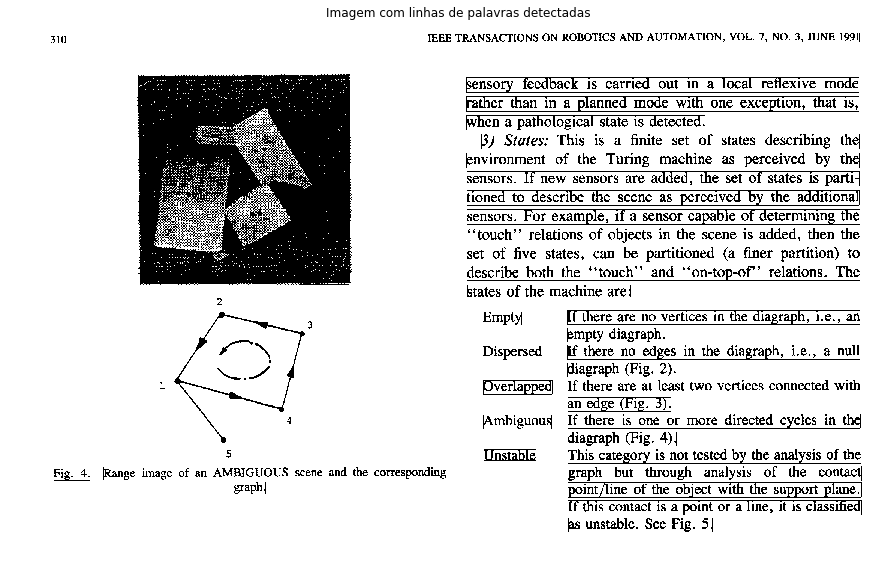

34

In [16]:
# Classify the texts and draw rectangles to the iamge containing lines
text_counts = 0
not_texts_counts = 0
texts_rectangles = []
line_count = 0
img_texts = img.copy()

for i, rectangle in enumerate(rectangles):
    top_left = rectangle[0]
    bottom_right = rectangle[1]
    component = get_subimg(img, top_left, bottom_right)

    # Savinf the results in different directories
    if classify_text(component):
        text_counts += 1
        save_image(component, 'res/{}/texts/{}.pbm'.format(IMAGE_NAME, text_counts))
        texts_rectangles.append(rectangle)
        
        top_left = rectangle[0]
        bottom_right = rectangle[1]
        draw_rectangle(img_texts, top_left, bottom_right)
        line_count += 1
    else:
        not_texts_counts += 1
        save_image(component, 'res/{}/not_texts/{}.pbm'.format(IMAGE_NAME, not_texts_counts))
        
plot_image(img_texts, "Imagem com linhas de palavras detectadas")
save_image(img_texts, 'res/{}/img_border_texts.pbm'.format(IMAGE_NAME))

# counts the total of the lines
line_count

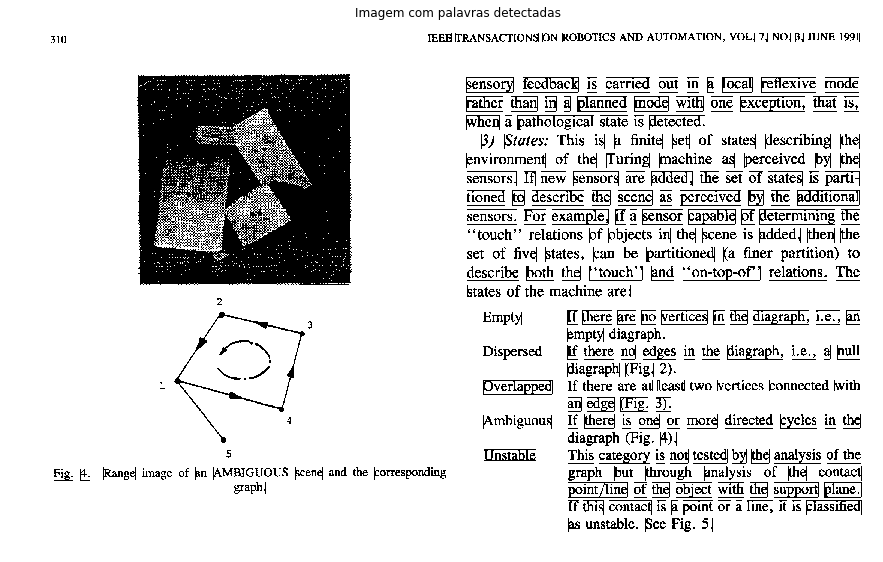

235

In [17]:
# For each line, separate each word
img_border_texts = img.copy()
word_count = 0

for i, rectangle in enumerate(texts_rectangles):
    top_left = rectangle[0]
    bottom_right = rectangle[1]
    
    # This factor is the size of the morphological structure
    # It variate by the height of the line, to catch different sizes of fonts
    factor = int((bottom_right[0] - top_left[0]) / 3.5)

    text_component = get_subimg(img, top_left, bottom_right)

    # Limit a maximum size of this structure (30 is the maximum)
    structure_3 = np.ones((min(3*factor, 30),min(factor, 30)))

    text_res = ndimage.binary_closing((text_component), structure_3, border_value=1).astype((text_component).dtype)

    word_rectangles = get_rectangles_conexed_components(text_res, text_component)
    
    for word_rectangle in word_rectangles:
        word_top_left = top_left[0] + word_rectangle[0][0], top_left[1] + word_rectangle[0][1]
        word_bottom_right = top_left[0] + word_rectangle[1][0], top_left[1] + word_rectangle[1][1]
        draw_rectangle(img_border_texts, word_top_left, word_bottom_right)
        word_count += 1

plot_image(img_border_texts, "Imagem com palavras detectadas")
save_image(img_border_texts, 'res/{}/img_border_words.pbm'.format(IMAGE_NAME))
# total words count
word_count